In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import argparse
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.autograd import Variable

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.get_device_name(0)

'GeForce GTX 960M'

In [5]:
torch.cuda.current_device()

0

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5,],std=[0.5,])])

trainset=tv.datasets.MNIST(
  root='F:/study/Master/ML1/MNIST/',
  train=True,
  download=True,
  transform=transform
  )

testset=tv.datasets.MNIST(
  root='F:/study/Master/ML1/MNIST/',
  train=False,
  download=True,
  transform=transform
  )


#data load
trainloader=torch.utils.data.DataLoader(
  trainset,
  batch_size=64,
  shuffle = True,
  num_workers=2
  )



testloader=torch.utils.data.DataLoader(
  testset,
  batch_size=64,
  shuffle= True,
  num_workers=2
  )


#RuntimeError: output with shape [1, 28, 28] doesn't match the broadcast shape [3, 28, 28]
#cause MNIST ist grey value pic with one canal,not three canals.

In [7]:
print(len(trainset))

60000


[tensor(9), tensor(7), tensor(1), tensor(3), tensor(1), tensor(5), tensor(9), tensor(0), tensor(9), tensor(3), tensor(3), tensor(6), tensor(2), tensor(4), tensor(2), tensor(6), tensor(5), tensor(9), tensor(4), tensor(7), tensor(9), tensor(4), tensor(7), tensor(4), tensor(0), tensor(0), tensor(4), tensor(3), tensor(3), tensor(5), tensor(4), tensor(9), tensor(9), tensor(6), tensor(2), tensor(1), tensor(2), tensor(8), tensor(1), tensor(2), tensor(6), tensor(0), tensor(6), tensor(4), tensor(6), tensor(1), tensor(8), tensor(7), tensor(0), tensor(3), tensor(9), tensor(3), tensor(8), tensor(4), tensor(1), tensor(4), tensor(7), tensor(4), tensor(5), tensor(8), tensor(6), tensor(1), tensor(4), tensor(9)]


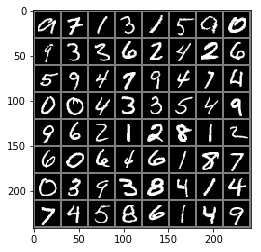

In [11]:
images,labels=next(iter(trainloader))
img=tv.utils.make_grid(images)

img=img.numpy().transpose(1,2,0)
std=[0.5,0.5,0.5]
mean=[0.5,0.5,0.5]
img=img*std+mean
print([labels[i] for i in range(64)])
plt.imshow(img)

In [14]:
# Neural Network
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv1=torch.nn.Sequential(torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                                       torch.nn.ReLU(),
                                       torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                       torch.nn.ReLU(),
                                       torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.dense=torch.nn.Sequential(torch.nn.Linear(14*14*128,1024),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(1024,10)
                                      )
    
    def forward(self,x):
        x=self.conv1(x)
        x=x.view(-1,14*14*128)
        x=self.dense(x)
        return x

In [15]:
model=Model()
cost=torch.nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters())
#model.load_state_dict(torch.load('model_parameter.pkl'))

In [16]:
# check the Structure
print(model)

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=25088, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [21]:
for epoch in range(4):
    running_loss=0.0
    running_correct=0
    print("Epoch{}/{}".format(epoch,4))
    print("-"*10)
    
    for data in trainloader:
        X_train, y_train = data
        X_train, y_train = Variable(X_train), Variable(y_train)
        outputs = model(X_train)
        _,pred = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = cost(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_correct += torch.sum(pred == y_train.data)
    testing_correct = 0
    for data in testloader:
        X_test, y_test = data
        X_test, y_test = Variable(X_test), Variable(y_test)
        outputs = model(X_test)
        _, pred = torch.max(outputs.data, 1)
        testing_correct += torch.sum(pred == y_test.data)
    print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}".format(running_loss/len(trainset),
                                                                                      100*running_correct/len(trainset),
                                                                                      100*testing_correct/len(testset)))


Epoch0/4
----------
Loss is:0.0005, Train Accuracy is:98.0000%, Test Accuracy is:98.0000
Epoch1/4
----------
Loss is:0.0004, Train Accuracy is:99.0000%, Test Accuracy is:98.0000
Epoch2/4
----------
Loss is:0.0003, Train Accuracy is:99.0000%, Test Accuracy is:98.0000
Epoch3/4
----------
Loss is:0.0002, Train Accuracy is:99.0000%, Test Accuracy is:98.0000


Predict Label is: [tensor(4), tensor(3), tensor(0), tensor(1)]
Real Label is: [tensor(4), tensor(3), tensor(0), tensor(1)]


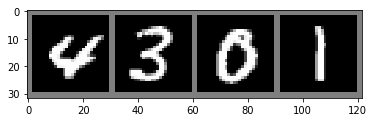

In [24]:
testloader = torch.utils.data.DataLoader(dataset=testset,
                                          batch_size = 4,
                                          shuffle = True)
X_test, y_test = next(iter(testloader))
inputs = Variable(X_test)
pred = model(inputs)
_,pred = torch.max(pred, 1)

print("Predict Label is:", [ i for i in pred.data])
print("Real Label is:",[i for i in y_test])

img = tv.utils.make_grid(X_test)
img = img.numpy().transpose(1,2,0)

std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
plt.imshow(img)